# Fundamentos de Ciencia de Datos

## Taller 2

**Nombre:** Alexis Mauricio Garzón Pardo

**Parte 0: Preparación**

* Exploración y limpieza de Datos:

    * Descargar el conjunto de datos Online Retail II.
    
    * Cargar el conjutno de datos utilizando pandas y realizar una exploración inicial para entender la estructura y contenido de los datos.
    * Limpiar los datos manejando valores faltantes, eliminando registros duplicados y filtrando entradas irrelevantes (por ejemplo, transacciones sin ID de clientes o pedidos cancelados).

* Análisis Exploratorio de Datos

    * Analizar la distribución de variables clave ( por ejemplo, cantidad de productos comprados, precio de los productos y fechas de compra).
    
    * Identificar los productos más vendidos y visualizar sus tendencias de ventas a lo largo del tiempo.
    
    * Explorar los patrones estacionales en los datos de venta e identificar los periodos de máxima ventas.

In [44]:
# Importamos las librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine
import json

In [45]:
# leer según extensión
data_path="Online_Retail_II.xlsx"
df = pd.read_excel(data_path, engine='openpyxl')
    
print("Archivo cargado:", data_path) #nombre del archivo
print("Dimensiones iniciales:", df.shape) #dimensión del archivo
df.head() # para inspección rápida

Archivo cargado: Online_Retail_II.xlsx
Dimensiones iniciales: (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [46]:
# 2. Inspección básica
df.info()
print("\nNulos por columna:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB

Nulos por columna:
 Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [47]:
# 3. Copia para trabajar y evitar modificar el original en memoria
df_clean = df.copy()

# 3.1 Normalizar nombres de columnas (por si hay espacios)
df_clean.columns = [c.strip() for c in df_clean.columns]

# 3.2 Convertir InvoiceDate a datetime (convertir fechas) y eliminar filas sin fecha
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean = df_clean.dropna(subset=['InvoiceDate'])

# 3.3  Normalizar cadenas básicas: Description, Country y StockCode:
df_clean['Description'] = df_clean['Description'].astype(str).str.strip()
df_clean['Country'] = df_clean['Country'].astype(str).str.strip().str.title()
df_clean['StockCode'] = df_clean['StockCode'].astype(str).str.strip()

# 3.4 Eliminar registros duplicados exactos (misma fila)
before_dup = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after_dup = df_clean.shape[0]
print(f"Duplicados eliminados: {before_dup - after_dup}")

# 3.5 Eliminar  Customer ID nulos:
before_id = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Customer ID'])
after_id = df_clean.shape[0]
print(f"Customer ID nulos eliminados: {before_id - after_id}")

# 3.6 Eliminar devoluciones (Invoice con 'C'), filas con cantidad o precio cero
before_in = df_clean.shape[0]
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
after_in = df_clean.shape[0]
print(f"Devoluciones eliminadas: {before_in - after_in}")

# 3.7 total price
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']


# 3.8 Reset índice final
df_clean = df_clean.reset_index(drop=True)
print("Dimensiones después de limpieza:", df_clean.shape)

Duplicados eliminados: 6865
Customer ID nulos eliminados: 107833
Devoluciones eliminadas: 9847
Dimensiones después de limpieza: (400916, 9)


In [48]:
# Verificamos el filtrado
df_clean.info()
df_clean.head() # para inspección rápida

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400916 entries, 0 to 400915
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   Customer ID  400916 non-null  float64       
 7   Country      400916 non-null  object        
 8   TotalPrice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.5+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [49]:
# 4. Guardar DataFrame limpio en SQLite
db_filename = "online_retail_clean_II.db"
engine = create_engine(f"sqlite:///{db_filename}", echo=False)

# Guardar tabla 'online_retail'
df_clean.to_sql("online_retail", con=engine, if_exists='replace', index=False)
print(f"Guardado en SQLite: {db_filename} -> tabla 'online_retail' con {df_clean.shape[0]} filas")

Guardado en SQLite: online_retail_clean_II.db -> tabla 'online_retail' con 400916 filas


In [50]:
# 5. Leer datos desde SQLite para verificar
with engine.connect() as conn:
    df_sql = pd.read_sql_table("online_retail", conn)

print("Dimensiones leídas desde SQLite:", df_sql.shape)
df_sql.head()

Dimensiones leídas desde SQLite: (400916, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [51]:
# 6.1 Descripción de campos (automática + comentarios)
meta = {}

for col in df_sql.columns:
    ser = df_sql[col]
    info = {
        "dtype": str(ser.dtype),
        "non_null": int(ser.count()),
        "nulls": int(ser.isna().sum()),
        "unique": int(ser.nunique(dropna=True)),
        "sample": ser.dropna().unique()[:5].tolist()
    }
    if pd.api.types.is_numeric_dtype(ser):
        info.update({
            "min": float(ser.min()),
            "max": float(ser.max()),
            "mean": float(ser.mean())
        })
    if pd.api.types.is_datetime64_any_dtype(ser):
        info.update({
            "min_date": str(ser.min()),
            "max_date": str(ser.max())
        })
    meta[col] = info

# Función para serializar Timestamps y numpy
def default_converter(o):
    if isinstance(o, (pd.Timestamp, np.datetime64)):
        return str(o)
    if isinstance(o, np.integer):
        return int(o)
    if isinstance(o, np.floating):
        return float(o)
    return str(o)

with open("metadata_online_retail.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False, default=default_converter)

print("Metadatos guardados en metadata_online_retail_II.json")

Metadatos guardados en metadata_online_retail_II.json


In [52]:
# 7. Estadísticas globales útiles
# Rango temporal
date_min, date_max = df_sql['InvoiceDate'].min(), df_sql['InvoiceDate'].max()

# Revenue sin devoluciones
total_revenue = df_sql['TotalPrice'].sum()

# Top productos
top_products = (df_sql
                .groupby('Description')['TotalPrice']
                .sum()
                .sort_values(ascending=False)
                .head(10))

# Top países
top_countries = (df_sql
                 .groupby('Country')['TotalPrice']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10))

print("Rango temporal:", date_min, "->", date_max)
print("Revenue total:", total_revenue)
print("\nTop 10 productos:\n", top_products)
print("\nTop 10 países:\n", top_countries)

Rango temporal: 2009-12-01 07:45:00 -> 2010-12-09 20:01:00
Revenue total: 8798233.743999999

Top 10 productos:
 Description
WHITE HANGING HEART T-LIGHT HOLDER     151339.16
REGENCY CAKESTAND 3 TIER               143727.60
Manual                                  98531.99
ASSORTED COLOUR BIRD ORNAMENT           70291.03
JUMBO BAG RED RETROSPOT                 51644.25
POSTAGE                                 48741.08
ROTATING SILVER ANGELS T-LIGHT HLDR     40156.05
PAPER CHAIN KIT 50'S CHRISTMAS          36871.55
PARTY BUNTING                           35017.30
EDWARDIAN PARASOL NATURAL               34044.75
Name: TotalPrice, dtype: float64

Top 10 países:
 Country
United Kingdom    7381644.433
Eire               356041.860
Netherlands        268784.350
Germany            202025.391
France             146107.070
Sweden              53147.990
Denmark             50906.850
Spain               47568.650
Switzerland         43921.390
Australia           31446.800
Name: TotalPrice, dtype: flo

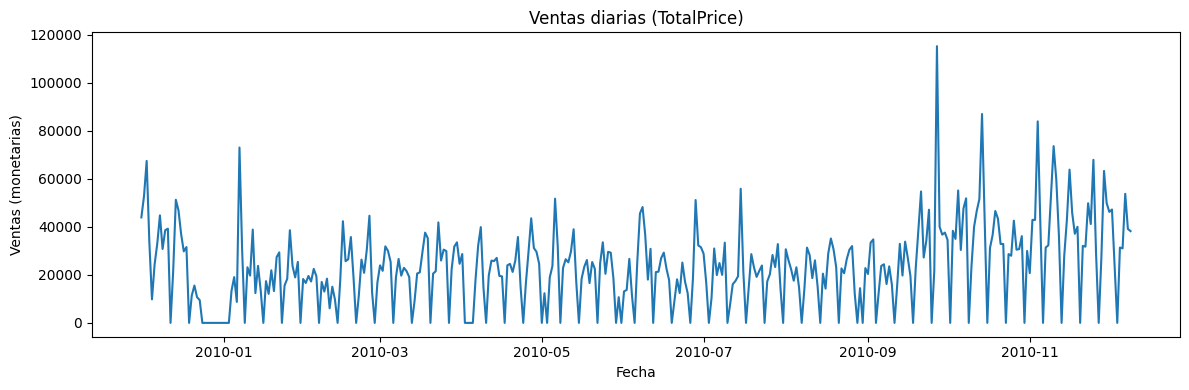

In [53]:
# A. Serie temporal: ventas diarias (suma TotalPrice por día)
daily = (df_sql
         .set_index('InvoiceDate')
         .resample('D')['TotalPrice']
         .sum()
         .fillna(0))

plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values)   # trazo de la serie
plt.title("Ventas diarias (TotalPrice)")
plt.xlabel("Fecha")
plt.ylabel("Ventas (monetarias)")
plt.tight_layout()
plt.savefig("ventas_diarias.png", dpi=150)
plt.show()

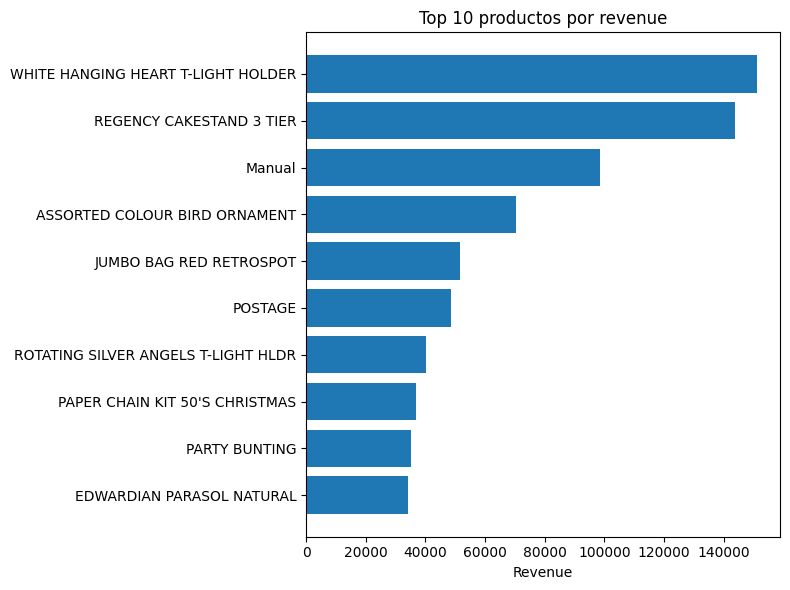

In [54]:
# B. Top 10 productos por revenue (barras horizontales)
top10 = top_products.sort_values()  # ordenar ascendente para barh
plt.figure(figsize=(8,6))
plt.barh(top10.index, top10.values)
plt.title("Top 10 productos por revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.savefig("top10_productos.png", dpi=150)
plt.show()

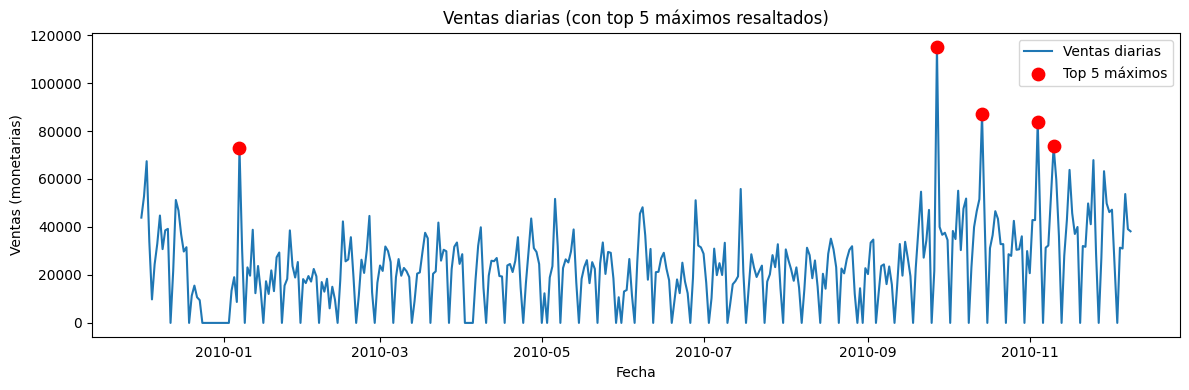

Top 5 días con más ventas:
InvoiceDate
2010-09-27    115172.24
2010-10-14     86945.13
2010-11-04     83876.12
2010-11-10     73575.93
2010-01-07     72989.38
Name: TotalPrice, dtype: float64


In [55]:
# Top 5 días con más ventas
top_days = daily.sort_values(ascending=False).head(5)

plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values, label="Ventas diarias")
plt.scatter(top_days.index, top_days.values, color="red", s=80, zorder=5, label="Top 5 máximos")
plt.title("Ventas diarias (con top 5 máximos resaltados)")
plt.xlabel("Fecha")
plt.ylabel("Ventas (monetarias)")
plt.legend()
plt.tight_layout()
plt.show()

print("Top 5 días con más ventas:")
print(top_days)

In [56]:
# Calcular ventas diarias
daily = (df_sql
         .set_index('InvoiceDate')
         .resample('D')['TotalPrice']
         .sum()
         .fillna(0))

# Top 5 días
top_days = daily.sort_values(ascending=False).head(5)
print("Top 5 días con mayor venta:\n", top_days)

Top 5 días con mayor venta:
 InvoiceDate
2010-09-27    115172.24
2010-10-14     86945.13
2010-11-04     83876.12
2010-11-10     73575.93
2010-01-07     72989.38
Name: TotalPrice, dtype: float64


In [57]:
# Filtrar el dataframe por los días seleccionados
df_top_days = df_sql[df_sql['InvoiceDate'].dt.date.isin(top_days.index.date)]

In [58]:
# Sumar ventas por producto en esos días
productos_top_dias = (df_top_days
                      .groupby('Description')['TotalPrice']
                      .sum()
                      .sort_values(ascending=False))

print("Productos más vendidos en esos 5 días:\n", productos_top_dias.head(10))

Productos más vendidos en esos 5 días:
 Description
ROTATING SILVER ANGELS T-LIGHT HLDR    16651.35
Manual                                 15767.07
WHITE HANGING HEART T-LIGHT HOLDER      7251.77
VINTAGE UNION JACK MEMOBOARD            5713.58
REGENCY CAKESTAND 3 TIER                4745.85
VINTAGE UNION JACK CUSHION COVER        4578.57
WOOD BLACK BOARD ANT WHITE FINISH       4167.03
VINTAGE UNION JACK BUNTING              4060.96
VINTAGE UNION JACK DOORSTOP             4010.83
MIRROR, ARCHED GEORGIAN                 3884.00
Name: TotalPrice, dtype: float64


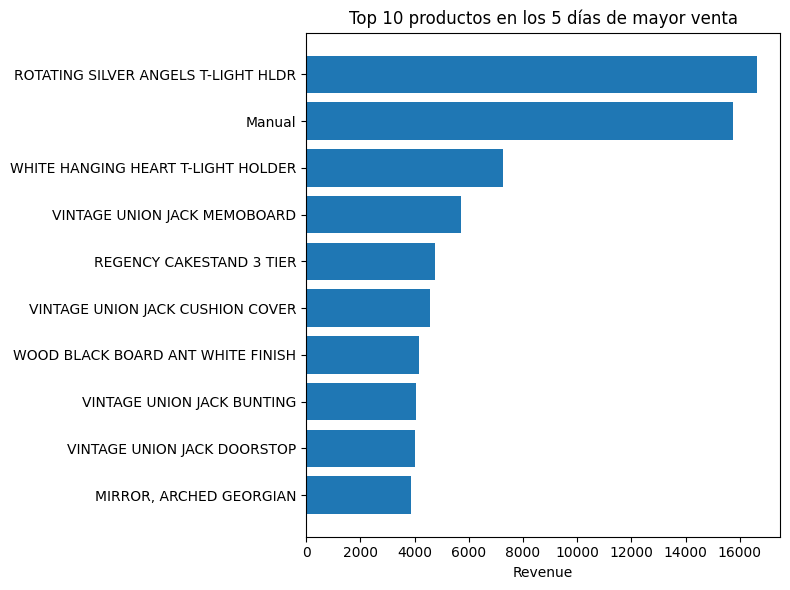

In [59]:
# Top 10 productos en los top 5 días
top10_prod_topdays = productos_top_dias.head(10).sort_values()

plt.figure(figsize=(8,6))
plt.barh(top10_prod_topdays.index, top10_prod_topdays.values)
plt.title("Top 10 productos en los 5 días de mayor venta")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()

**Parte 1: Clasificación de clientes:**
* Definir una nueva columna en los datos para trabajar con dos clases: “Clientes Normales” y “Clientes Premium”. ¿Cómo podríamos definir estas categorías, por volumen de compras, cantidades, etc? Definir este campo.
*  Entrenar un modelo de clasificación para la clasificación de los clientes en estas dos categorías.

In [60]:
# Revenue total por cliente
clientes_revenue = df_sql.groupby('Customer ID')['TotalPrice'].sum()

# Umbral para premium (percentil 80)
threshold = clientes_revenue.quantile(0.8)

# Nueva columna de clase
clientes = clientes_revenue.reset_index()
clientes['Categoria'] = clientes['TotalPrice'].apply(
    lambda x: 'Premium' if x >= threshold else 'Normal'
)

print(clientes['Categoria'].value_counts())
clientes.head()

Categoria
Normal     3449
Premium     863
Name: count, dtype: int64


,Customer ID,TotalPrice,Categoria
0,12346.0,372.86,Normal
1,12347.0,1323.32,Normal
2,12348.0,222.16,Normal
3,12349.0,2671.14,Premium
4,12351.0,300.93,Normal


Preparamos los datos para el modelo:

In [61]:
# Features por cliente
features = (df_sql.groupby('Customer ID')
            .agg({
                'TotalPrice':'sum',
                'Quantity':'sum',
                'Invoice':'nunique'
            })
            .reset_index())

# Merge con etiquetas
data = features.merge(clientes[['Customer ID','Categoria']], on='Customer ID')

X = data[['TotalPrice','Quantity','Invoice']]   # variables predictoras
y = data['Categoria']                           # variable objetivo

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Entrenamos varios modelos (3):

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modelo 1: Regresión Logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log))

# Modelo 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Modelo 3: KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred_knn))

Logistic Regression:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       1.00      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863

Random Forest:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       1.00      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863

KNN:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       0.99      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1

Modelo elegido:

In [63]:
# Definir etiquetas por revenue total
clientes_revenue = df_sql.groupby('Customer ID')['TotalPrice'].sum()
threshold = clientes_revenue.quantile(0.8)

clientes = clientes_revenue.reset_index()
clientes['Categoria'] = clientes['TotalPrice'].apply(
    lambda x: 'Premium' if x >= threshold else 'Normal'
)

# Features SIN usar TotalPrice (para evitar leakage)
features = (df_sql.groupby('Customer ID')
            .agg({
                'Quantity':'sum',
                'Invoice':'nunique'
            })
            .reset_index())

# Merge con labels
data = features.merge(clientes[['Customer ID','Categoria']], on='Customer ID')
X = data[['Quantity','Invoice']]
y = data['Categoria']

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modelo 1: Regresión Logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log))

# Modelo 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Modelo 3: KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred_knn))

Logistic Regression:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       1.00      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863

Random Forest:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       1.00      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863

KNN:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       690
     Premium       0.99      1.00      1.00       173

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1

Creamos un Pipeline + GridSearchCV para entrenar Logistic Regression, Random Forest y KNN con hiperparámetros ajustados.

Configurar los modelos en Pipelines:

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Diccionario de pipelines
pipelines = {
    'logreg': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'rf': Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', KNeighborsClassifier())
    ])
}

In [66]:
param_grid = {
    'logreg': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'rf': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 5, 10]
    },
    'knn': {
        'clf__n_neighbors': [3, 5, 7, 11],
        'clf__weights': ['uniform', 'distance']
    }
}

In [67]:
from sklearn.metrics import classification_report, accuracy_score

best_models = {}

for name, pipeline in pipelines.items():
    print(f"\n=== Entrenando {name.upper()} ===")
    grid = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print("Mejores parámetros:", grid.best_params_)
    print("Accuracy en test:", acc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
    
    best_models[name] = (grid.best_estimator_, acc)


=== Entrenando LOGREG ===
Mejores parámetros: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Accuracy en test: 0.9397450753186558
Reporte de clasificación:
               precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       690
     Premium       0.92      0.76      0.84       173

    accuracy                           0.94       863
   macro avg       0.93      0.87      0.90       863
weighted avg       0.94      0.94      0.94       863


=== Entrenando RF ===
Mejores parámetros: {'clf__max_depth': 5, 'clf__n_estimators': 200}
Accuracy en test: 0.9501738122827347
Reporte de clasificación:
               precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       690
     Premium       0.89      0.86      0.87       173

    accuracy                           0.95       863
   macro avg       0.93      0.91      0.92       863
weighted avg       0.95      0.95      0.95       863


=== Entrenando KNN

In [68]:
# Comparación final
for model, (estimator, acc) in best_models.items():
    print(f"{model.upper()} → Accuracy: {acc:.3f}")

best_model_name = max(best_models, key=lambda m: best_models[m][1])
print(f"\n✅ El mejor modelo fue: {best_model_name.upper()} con accuracy = {best_models[best_model_name][1]:.3f}")

LOGREG → Accuracy: 0.940
RF → Accuracy: 0.950
KNN → Accuracy: 0.946

✅ El mejor modelo fue: RF con accuracy = 0.950


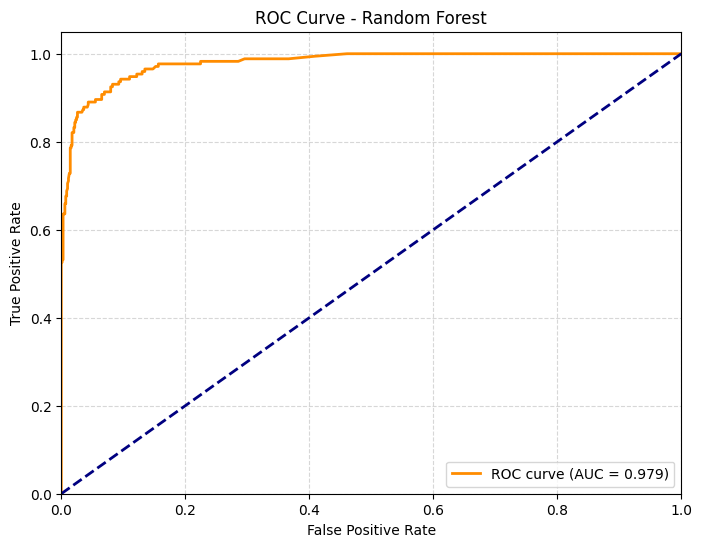

In [69]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Mejor modelo
best_estimator = best_models['rf'][0]

# Obtener probabilidades de la clase positiva ("Premium")
y_prob = best_estimator.predict_proba(X_test)[:, 1]

# Calcular ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Premium')  # asegúrate de que la clase positiva esté correcta
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Parte 2: Segmentación de Clientes**
* Usar el agrupamiento K-means para categorizar a los clientes en grupos distintos y analizar las características de cada segmento.
*  Usar el agrupamiento Mean Shift para categorizar a los clientes en grupos distintos y analizar las características de cada segmento.
* Comparar los resultados de las dos técnicas anteriores

In [26]:
from sklearn.preprocessing import StandardScaler

# Variables por cliente
features_seg = (df_sql.groupby('Customer ID')
                .agg({
                    'TotalPrice':'sum',
                    'Quantity':'sum',
                    'Invoice':'nunique'
                })
                .reset_index())

X_seg = features_seg[['TotalPrice','Quantity','Invoice']]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

k-means Clustering

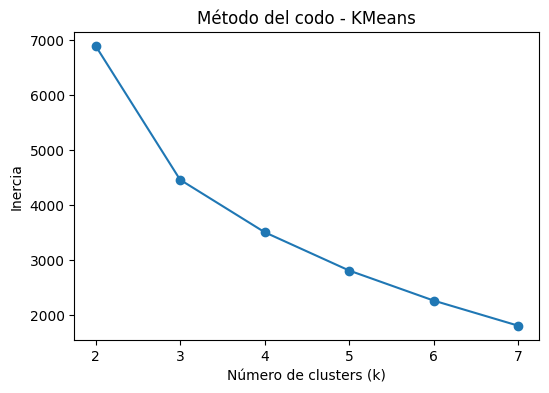

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_clean['Description'] = df_clean['Description'].astype(str).str.strip()
df_clean['Country'] = df_clean['Country'].astype(str).str.strip().str.title()
df_clean['StockCode'] = df_clean['StockCode'].astype(str).str.strip()

# Elbow method para elegir k
inertia = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Método del codo - KMeans")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.show()

In [28]:
# Entrenar con k=3 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features_seg['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

In [29]:
from sklearn.cluster import MeanShift

ms = MeanShift()
features_seg['Cluster_MeanShift'] = ms.fit_predict(X_scaled)

print("Número de clusters encontrados con MeanShift:", len(set(features_seg['Cluster_MeanShift'])))

Número de clusters encontrados con MeanShift: 73


MeanShift encontró 73 clusters, lo que refleja la gran dispersión en el comportamiento de los clientes. Sin embargo, para fines de segmentación de negocio, KMeans con 3–4 clusters ofrece una representación más clara y manejable. MeanShift, en cambio, es útil para detectar clientes muy atípicos o grupos pequeños de alto valor.

In [30]:
# Resumen por cluster - KMeans
kmeans_summary = features_seg.groupby('Cluster_KMeans')[['TotalPrice','Quantity','Invoice']].mean()

# Resumen por cluster - MeanShift
meanshift_summary = features_seg.groupby('Cluster_MeanShift')[['TotalPrice','Quantity','Invoice']].mean()

print("\n=== KMeans Segmentos ===")
print(kmeans_summary)

print("\n=== MeanShift Segmentos ===")
print(meanshift_summary)


=== KMeans Segmentos ===
                   TotalPrice       Quantity    Invoice
Cluster_KMeans                                         
0                 1424.249756     818.562691   3.795578
1               185295.043333  136466.833333  95.500000
2                29672.323145   22201.218182  45.545455

=== MeanShift Segmentos ===
                     TotalPrice      Quantity    Invoice
Cluster_MeanShift                                       
0                    980.154923    566.060821   3.019767
1                   8953.085000   4491.760000  18.220000
2                  19137.304000   9713.200000  39.200000
3                   7074.623214   3086.428571   6.678571
4                   8119.881176   5955.235294   6.411765
...                         ...           ...        ...
68                  9783.700000  10077.500000  21.500000
69                 10327.200000  25560.000000  13.000000
70                  7207.890000  14423.000000   6.000000
71                  4505.281418   2791

* Cluster 0 (Clientes pequeños / normales)
    * Gasto medio: ~1,400
    * Pocas compras (~4 facturas, 800 unidades)
    * Segmento más grande → clientes ocasionales.
* Cluster 2 (Clientes medios)
    * Gasto medio: ~29,600
    * Compran mucho más (22,200 productos, 45 facturas)
    * Grupo importante pero no VIP.
* Cluster 1 (Clientes Premium / VIP)
    * Gasto medio: ~185,000
    * Muchísimas compras (~136k productos, 95 facturas)
    * Grupo muy reducido pero hiper valioso.


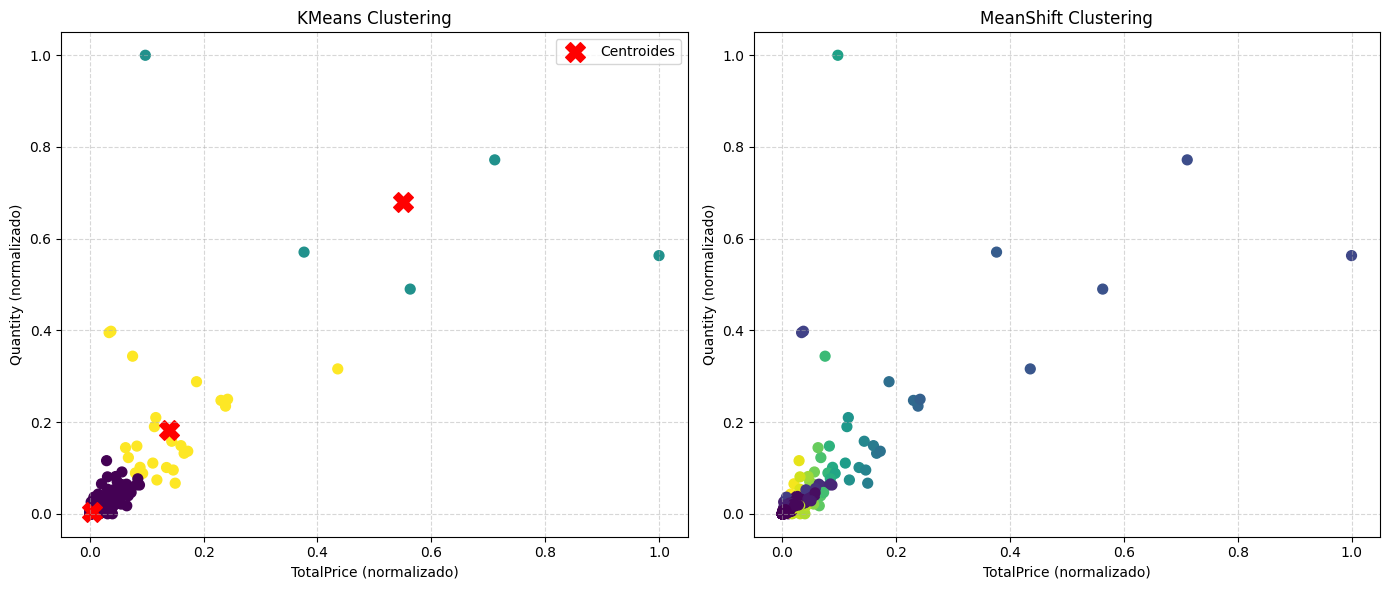

In [72]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MeanShift

# Escalado opcional para visualización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_seg[['TotalPrice','Quantity']])

# KMeans con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features_seg['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)
kmeans_centers = kmeans.cluster_centers_

# MeanShift
meanshift = MeanShift()
features_seg['Cluster_MeanShift'] = meanshift.fit_predict(X_scaled)
meanshift_centers = meanshift.cluster_centers_

# Graficar
plt.figure(figsize=(14,6))

# KMeans
plt.subplot(1,2,1)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=features_seg['Cluster_KMeans'], cmap='viridis', s=50)
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c='red', s=200, marker='X', label='Centroides')
plt.title('KMeans Clustering')
plt.xlabel('TotalPrice (normalizado)')
plt.ylabel('Quantity (normalizado)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# MeanShift
plt.subplot(1,2,2)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=features_seg['Cluster_MeanShift'], cmap='viridis', s=50)
plt.title('MeanShift Clustering')
plt.xlabel('TotalPrice (normalizado)')
plt.ylabel('Quantity (normalizado)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Con KMeans, se identificaron 3 segmentos claros de clientes: Normales, Medios y Premium, lo que facilita acciones de marketing diferenciadas. En contraste, MeanShift detectó 73 grupos, mostrando la dispersión natural de los datos y revelando micro-segmentos específicos. Sin embargo, dado que un número tan elevado de clusters resulta difícil de manejar, KMeans se presenta como la técnica más adecuada para la segmentación práctica, mientras que MeanShift es útil como herramienta exploratoria para descubrir clientes atípicos o nichos pequeños de alto valor

**Parte 3: Predicción de Ventas** 
* Crear nuevas características, si es necesario, para ayudar en el modelado predictivo (por ejemplo, época del año, categorías de productos).
* Dividir los datos en conjuntos de entrenamiento y prueba.
* Elegir un algoritmo de aprendizaje automático adecuado (por ejemplo, regresión lineal, árbol de decisión o bosque aleatorio) para predecir ventas futuras.
* Evaluar el modelo utilizando métricas de rendimiento apropiadas.

In [31]:
# Ventas diarias
daily_sales = (df_sql
               .groupby(df_sql['InvoiceDate'].dt.date)['TotalPrice']
               .sum()
               .reset_index())

daily_sales.columns = ['Date', 'Sales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# Crear nuevas features
daily_sales['Month'] = daily_sales['Date'].dt.month
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['IsWeekend'] = daily_sales['DayOfWeek'].apply(lambda x: 1 if x>=5 else 0)

daily_sales.head()

,Date,Sales,Month,DayOfWeek,IsWeekend
0,2009-12-01,43894.87,12,1,0
1,2009-12-02,52762.06,12,2,0
2,2009-12-03,67413.62,12,3,0
3,2009-12-04,33913.81,12,4,0
4,2009-12-05,9803.05,12,5,1


In [32]:
from sklearn.model_selection import train_test_split

X = daily_sales[['Month','DayOfWeek','IsWeekend']]
y = daily_sales['Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False # sin barajar, para respetar la serie temporal
)

Probamos modelos de predicción

Vamos a probar tres:
* Regresión Lineal (base simple).
* Árbol de Decisión (captura relaciones no lineales).
* Random Forest (mejor en generalización).

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results

{'Linear Regression': {'MAE': 13273.401688494885,
  'RMSE': 17803.712719539046,
  'R2': -0.7164173338318995},
 'Decision Tree': {'MAE': 13143.450648041477,
  'RMSE': 16680.494262643482,
  'R2': -0.5066749448411341},
 'Random Forest': {'MAE': 13316.209532333265,
  'RMSE': 16889.531383088506,
  'R2': -0.5446743521836002}}

In [34]:
# Crear características de rezagos
daily_sales['Lag1'] = daily_sales['Sales'].shift(1)
daily_sales['Lag7'] = daily_sales['Sales'].shift(7)
daily_sales['Rolling7'] = daily_sales['Sales'].shift(1).rolling(7).mean()

# Eliminar valores NaN creados por los rezagos
daily_sales = daily_sales.dropna()

X = daily_sales[['Month','DayOfWeek','IsWeekend','Lag1','Lag7','Rolling7']]
y = daily_sales['Sales']

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results

{'Linear Regression': {'MAE': 11506.508809488929,
  'RMSE': 15991.361888824082,
  'R2': -0.3451014516644135},
 'Decision Tree': {'MAE': 12162.393319444443,
  'RMSE': 18052.517505734617,
  'R2': -0.7141928836482936},
 'Random Forest': {'MAE': 11812.496744166683,
  'RMSE': 15992.89565535951,
  'R2': -0.3453594872894614}}

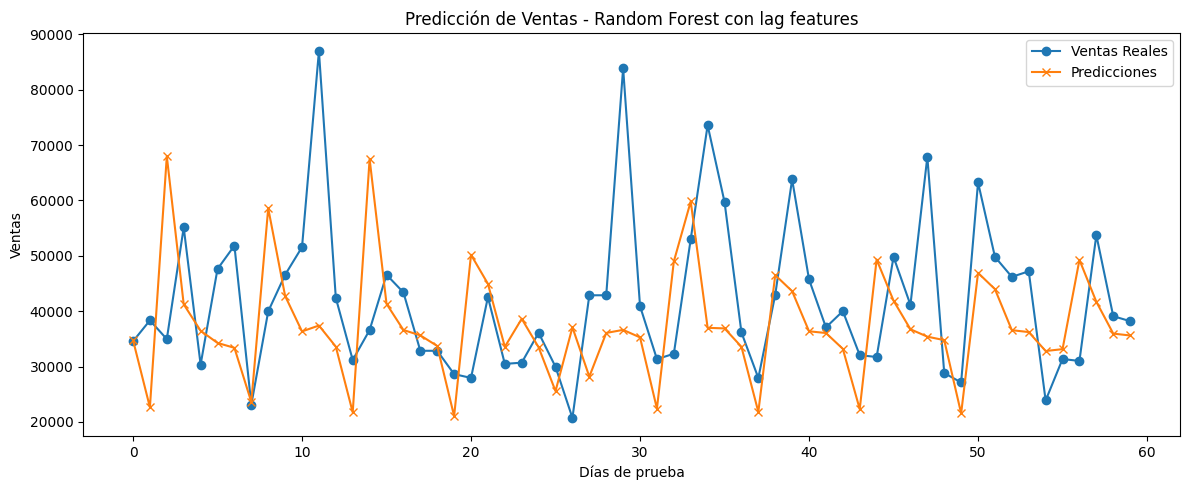

In [36]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Ventas Reales", marker='o')
plt.plot(y_pred, label="Predicciones", marker='x')
plt.title("Predicción de Ventas - Random Forest con lag features")
plt.xlabel("Días de prueba")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

Seleccionamos el mejor modelo según R². Usamos GridSearchCV para obtener el mejor estimador con sus hiperparámetros óptimos.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Definir modelos
models = {
    "Linear Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ]),
    "Decision Tree": Pipeline([
        ('dt', DecisionTreeRegressor(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('rf', RandomForestRegressor(random_state=42))
    ])
}

# Definir grid de hiperparámetros
param_grids = {
    "Linear Regression": {},  # no tiene hiperparámetros
    "Decision Tree": {
        'dt__max_depth': [3, 5, 7, 10, None],
        'dt__min_samples_split': [2, 5, 10],
        'dt__min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [5, 10, 15, None],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    }
}

results = {}

for name in models:
    print(f"Entrenando {name}...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "Best Params": grid.best_params_,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

results

Entrenando Linear Regression...
Entrenando Decision Tree...
Entrenando Random Forest...


{'Linear Regression': {'Best Params': {},
  'MAE': 11506.50880949229,
  'RMSE': 15991.361888827327,
  'R2': -0.3451014516649591},
 'Decision Tree': {'Best Params': {'dt__max_depth': 5,
   'dt__min_samples_leaf': 2,
   'dt__min_samples_split': 2},
  'MAE': 12194.529847222222,
  'RMSE': 17223.671881287024,
  'R2': -0.5603988622909843},
 'Random Forest': {'Best Params': {'rf__max_depth': 10,
   'rf__min_samples_leaf': 4,
   'rf__min_samples_split': 2,
   'rf__n_estimators': 50},
  'MAE': 9801.507795468688,
  'RMSE': 13977.539776310387,
  'R2': -0.0276509116516237}}

Mejor modelo: Random Forest


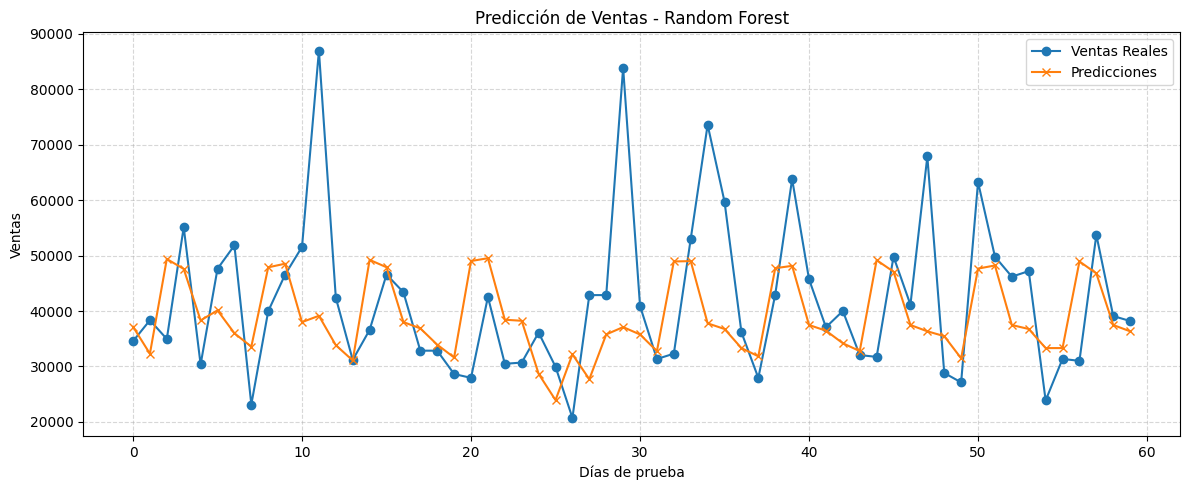

In [42]:
import matplotlib.pyplot as plt

# Identificar el mejor modelo según R2 o RMSE
best_model_name = max(results, key=lambda k: results[k]['R2'])
print("Mejor modelo:", best_model_name)

# Re-entrenar o usar el mejor estimador del GridSearchCV
if best_model_name == "Linear Regression":
    best_grid = GridSearchCV(estimator=models["Linear Regression"],
                             param_grid=param_grids["Linear Regression"],
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elif best_model_name == "Decision Tree":
    best_grid = GridSearchCV(estimator=models["Decision Tree"],
                             param_grid=param_grids["Decision Tree"],
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
else:  # Random Forest
    best_grid = GridSearchCV(estimator=models["Random Forest"],
                             param_grid=param_grids["Random Forest"],
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar de nuevo sobre X_train (opcional si ya tienes el GridSearchCV)
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

# Graficar
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Ventas Reales", marker='o')
plt.plot(y_pred, label="Predicciones", marker='x')
plt.title(f"Predicción de Ventas - {best_model_name}")
plt.xlabel("Días de prueba")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()